In [8]:
# @title Imports
from dataclasses import dataclass
import datetime, pytz
import enum
import functools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
from typing import Final, Sequence
from typing import Optional
from typing import Union, cast
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
from absl import logging
import gin
import gin
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import reverb
import mediapy as media
from IPython.display import clear_output
import sys

gin.enter_interactive_mode()

In [9]:
from smart_control.environment import environment

from smart_control.proto import smart_control_building_pb2, smart_control_normalization_pb2
from smart_control.reward import electricity_energy_cost, natural_gas_energy_cost, setpoint_energy_carbon_reward, setpoint_energy_carbon_regret

from smart_control.simulator import randomized_arrival_departure_occupancy, rejection_simulator_building
from smart_control.simulator import simulator_building, step_function_occupancy, stochastic_convection_simulator

from smart_control.utils import bounded_action_normalizer, building_renderer, controller_reader
from smart_control.utils import controller_writer, conversion_utils, observation_normalizer, reader_lib
from smart_control.utils import writer_lib, histogram_reducer, environment_utils

In [10]:
def logging_info(*args):
    logging.info(*args)
    print(*args)

def remap_filepath(filepath) -> str:
    return str(filepath)

In [11]:
# @title Plotting Utities
reward_shift = 0
reward_scale = 1.0
person_productivity_hour = 300.0

KELVIN_TO_CELSIUS = 273.15

def render_env(env: environment.Environment):
    """Renders the environment."""
    building_layout = env.building._simulator._building._floor_plan

    # create a renderer
    renderer = building_renderer.BuildingRenderer(building_layout, 1)

    # get the current temps to render
    # this also is not ideal, since the temps are not fully exposed.
    # V Ideally this should be a publicly accessable field
    temps = env.building._simulator._building.temp

    input_q = env.building._simulator._building.input_q

    # render
    vmin = 285
    vmax = 305
    image = renderer.render(temps, cmap='bwr', vmin=vmin, vmax=vmax, colorbar=False, 
                            input_q=input_q, diff_range=0.5, diff_size=1,).convert('RGB')
    media.show_image(image, title='Environment %s' % env.current_simulation_timestamp)

In [12]:
from plot_utils import *

In [13]:
data_path = "/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/burg/home/ssa2206/sbsim_dual_control/metrics" #@param {type:"string"}
output_data_path = '/burg/home/ssa2206/sbsim_dual_contarol/output' #@param {type:"string"}
root_dir = "/burg/home/ssa2206/sbsim_dual_control/root" #@param {type:"string"}

In [14]:
time_zone = 'US/Pacific'

In [15]:
from env_loader import load_envs

### Loading Environment

In [16]:
eval_env, collect_env, initial_collect_env = load_envs(data_path, metrics_path=None)

/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin
/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin


/burg/home/ssa2206/sbsim_dual_control/smart_control/simulator/building_utils.py:283: UserWarning: Connected components is showing that there are 4 or fewer
     rooms in your building. You may have your 0's and 1's inverted in the
     floor_plan. Remember that for the connectedComponents function,
     0's must code for exterior space and exterior or interior walls,
     and 1's must code for interior space.
  warnings.warn("""Connected components is showing that there are 4 or fewer
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricity_energy_cost.py:147: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(carbon_emission_rates) / 1.0e6 / 3600.0
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricity_energy_cost.py:152: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  np.array(weekday_energy_prices)
/burg/home/ssa2206/sbsim_dual_control/smart_control/reward/electricit

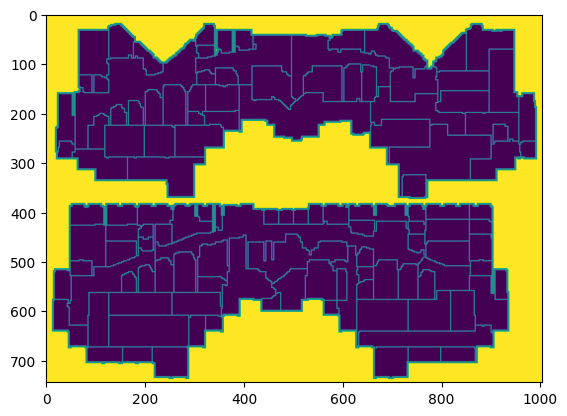

In [17]:
plt.imshow(eval_env.building._simulator._building._floor_plan)

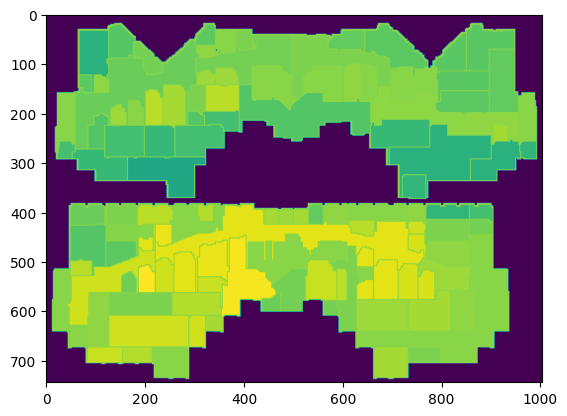

In [21]:
plt.imshow(eval_env.building._simulator._building.temp)

Environment 2023-07-06 07:00:00+00:00

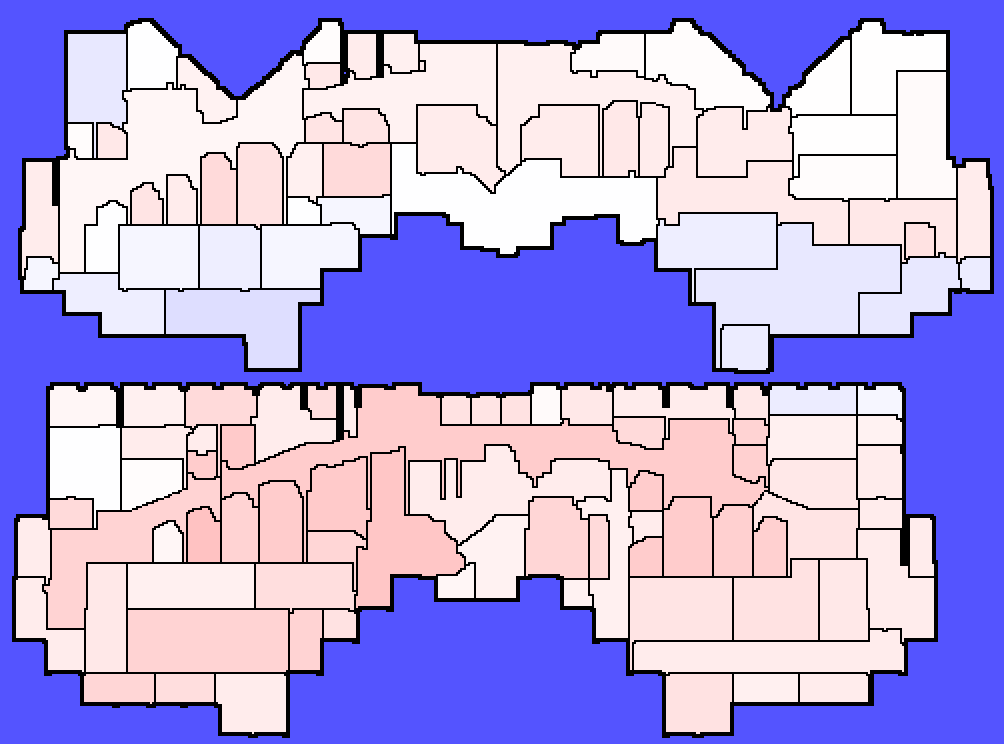

In [22]:
render_env(eval_env)

In [23]:
eval_env.building._device_infos[0]

device_id: "boiler_id_7f543f53-7254-4713-a03f-8dbc3d7c66ab"
namespace: "device_namespace_f74bc819-61e6-40fe-97b7-b75d064f6d59"
code: "device_code_67a9cd25-813a-4b85-bf4b-df50ab49f0a9"
zone_id: "default_zone_id"
device_type: BLR
observable_fields {
  key: "heating_request_count"
  value: VALUE_CONTINUOUS
}
observable_fields {
  key: "supply_water_setpoint"
  value: VALUE_CONTINUOUS
}
observable_fields {
  key: "supply_water_temperature_sensor"
  value: VALUE_CONTINUOUS
}
action_fields {
  key: "supply_water_setpoint"
  value: VALUE_CONTINUOUS
}

In [24]:
eval_env.building.request_observations

<bound method SimulatorBuilding.request_observations of <smart_control.simulator.simulator_building.SimulatorBuilding object at 0x1554ce957310>>

In [25]:
eval_env.building.zones[5]

zone_id: "zone_id_6"
building_id: "US-SIM-001"
zone_description: "Simulated zone"
devices: "vav_room_6"
zone_type: ROOM

In [26]:
eval_env.building._simulator

## Understanding State Space

In [27]:
timestep = eval_env.reset()

In [28]:
type(timestep)

tf_agents.trajectories.time_step.TimeStep

At each time index, the environment returns 
- the discounting rate $\gamma$
- Observation state vector $\in \mathbb{R}^{53}$
- Reward
- Step Type $\in \{front, mid, end\}$

In [29]:
timestep

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-20.        , -19.128613  ,   0.        ,  -0.82162595,
        -0.5831852 ,   4.8570604 ,   0.        ,  -2.425231  ,
        -1.1068594 ,   0.        ,   2.564033  ,   1.4996233 ,
         1.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.25881904,   0.9659258 ,
        -0.90096885,   0.43388373,   0.        ,   0.        ,
        -0.99206346], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [30]:
field_states = eval_env._field_names # what each state dimension represents

In [31]:
field_states[:5]

['air_handler_id_1f2272ab-e3cb-42eb-9499-ec6a180d253a_cooling_request_count',
 'air_handler_id_1f2272ab-e3cb-42eb-9499-ec6a180d253a_differential_pressure_setpoint',
 'air_handler_id_1f2272ab-e3cb-42eb-9499-ec6a180d253a_discharge_fan_speed_percentage_command',
 'air_handler_id_1f2272ab-e3cb-42eb-9499-ec6a180d253a_outside_air_flowrate_sensor',
 'air_handler_id_1f2272ab-e3cb-42eb-9499-ec6a180d253a_outside_air_temperature_sensor']

In [32]:
def label_obs_vector(obs):
    return(pd.Series(data=observation, index=field_states))

### Reward Model

Reward is evaluated from the state of the building, based on _simulator 

In [33]:
self = eval_env.building

In [34]:
occ = self._occupancy

##### Aggregates Info from Simulator, for each zone and the devices (boiler and AC)

- smart_control.proto.smart_control_reward_pb2.RewardInfo

In [35]:
reward_info = self._simulator.reward_info(self._occupancy)

##### reward info is computed for each zone and device. The setpoint refers to what temperature 

In [36]:
reward_info.zone_reward_infos

{'zone_id_104': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 295.3722229003906
air_flow_rate_setpoint: 0.03500000014901161
, 'zone_id_121': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 296.5944519042969
air_flow_rate_setpoint: 0.03500000014901161
, 'zone_id_42': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 294.3722229003906
air_flow_rate_setpoint: 0.03500000014901161
, 'zone_id_105': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 295.7611083984375
air_flow_rate_setpoint: 0.03500000014901161
, 'zone_id_10': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 295.48333740234375
air_flow_rate_setpoint: 0.03500000014901161
, 'zone_id_25': heating_setpoint_temperature: 289.0
cooling_setpoint_temperature: 298.0
zone_air_temperature: 295.0944519042969
air_flow_

In [37]:
eval_env.reward_function.compute_reward

<bound method SetpointEnergyCarbonRegretFunction.compute_reward of <smart_control.reward.setpoint_energy_carbon_regret.SetpointEnergyCarbonRegretFunction object at 0x1554ceae0bb0>>

In [38]:
eval_env.reward_function.compute_reward(reward_info)

agent_reward_value: -0.000474373169708997
natural_gas_energy_cost: 0.000852535362355411
carbon_emitted: 0.006689317524433136
productivity_weight: 0.20000000298023224
energy_cost_weight: 0.4000000059604645
carbon_emission_weight: 0.4000000059604645
person_productivity: 300.0
reward_scale: 1.0
normalized_energy_cost: 0.0002689380489755422
normalized_carbon_emission: 0.0009169948752969503
start_timestamp {
  seconds: 1688626800
}
end_timestamp {
  seconds: 1688627100
}


For this pilot there are three principal factors that contribute to the
reward function:
  * Setpoint: Maintaining the zone temperatures within heating and cooling
  setpoints  results in a positive reward, and any temperature outside of
  setpoints may also result in a negative reward (i.e., penalty).
  * Cost: The cost of electricity and natural gas is a negative reward (cost).
  Then by minimizing negative rewards/maximizing positive reward, the agent
  will reduce overall energy cost. To compute the cost, both energy consumption
  and the energy cost schedules are required.
  * Carbon: By receiving negative reward for consuming natural gas, the agent
  will learn to shift energy use to renewable sources. This factor requires an
  energy-to-carbon conversion formula/table.

The three factors can be scaled and combined into a single regret function:
        r_i = [u x (s(setpoint) - s_max)/s_max
            - v x f(cost)/f_max - w x g(carbon)/g_max]
            / [u + v + w]

        $$r_i -> [-1, 0] $$
where:
  r_i is the incremental reward at step i
  s(setpoint) is the reward for maintining temperature inside setpoint
  s_max = occupancy x productivity, the maximum possible reward
  f(cost) is the cost of consuming electrical and natural gas energy
  f_max: maximum momentary cost that occurs at max energy use
  g(carbon) is the cost of emitting carbon,
  g_max
  and u, w, w are weighing factors for the policy.

# Action Space

In [18]:
import tensorflow as tf
from tf_agents.agents.sac import sac_agent, tanh_normal_projection_network
from tf_agents.drivers import py_driver
from tf_agents.keras_layers import inner_reshape
from tf_agents.metrics import py_metrics
from tf_agents.networks import nest_map, sequential
from tf_agents.policies import greedy_policy, py_tf_eager_policy, random_py_policy, tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.train import actor, learner, triggers
from tf_agents.train.utils import spec_utils, train_utils
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory as trajectory_lib
from tf_agents.typing import types

In [19]:
def get_trajectory(time_step, current_action: policy_step.PolicyStep):
    """Get the trajectory for the current action and time step."""
    observation = time_step.observation
    action = current_action.action
    policy_info = ()
    reward = time_step.reward
    discount = time_step.discount

    if time_step.is_first():
        return(trajectory.first(observation, action, policy_info, reward, discount))
    elif time_step.is_last():
        return(trajectory.last(observation, action, policy_info, reward, discount))
    else:
        return(trajectory.mid(observation, action, policy_info, reward, discount))



### Rules Based Policy

Next, we parameterize the setpoint schedule.

We distinguish between weekend and holiday schedules:

* For **weekdays, between 6:00 am and 7:00 pm local time** we maintain occupancy conditions:
  * AC/Heatpump supply air heating setpoint is 12 C
  * Supply water temperarure is 77 C
* For **weekday, before 6:00 am and after 7:00 pm locl time** we maintain efficiency conditions (setback):
  * AC/Heatpump supply air heating setpoint is 0 C
  * Supply water temperarure is 42 C

* For **weekends and holdidays**, all day, we maintain efficiency conditions (setback):
  * AC/Heatpump supply air heating setpoint is 0 C
  * Supply water temperarure is 42 C

In [20]:
ts = collect_env.reset()
local_start_time = collect_env.current_simulation_timestamp.tz_convert(tz = 'US/Pacific')
action_normalizers = collect_env._action_normalizers

In [21]:
from run_utils import SchedulePolicy
observation_spec, action_spec, time_step_spec = spec_utils.get_tensor_specs(collect_env)
hod_cos_index = collect_env._field_names.index('hod_cos_000')
hod_sin_index = collect_env._field_names.index('hod_sin_000')
dow_cos_index = collect_env._field_names.index('dow_cos_000')
dow_sin_index = collect_env._field_names.index('dow_sin_000')
schedule_policy = SchedulePolicy(
    time_step_spec= time_step_spec,
    action_spec= action_spec,
    dow_sin_index=dow_sin_index,
    dow_cos_index=dow_cos_index,
    hod_sin_index=hod_sin_index,
    hod_cos_index=hod_cos_index,
    local_start_time=local_start_time,
    action_normalizers=action_normalizers,

)

Policies will be saved to saved_model_dir: /burg/home/ssa2206/sbsim_dual_control/root/policies


In [22]:
action_map = schedule_policy._get_action(ts)
action_map

{(<DeviceType.HWS: 1>, 'supply_water_setpoint'): 315.0,
 (<DeviceType.AC: 0>, 'supply_air_heating_temperature_setpoint'): 285.0}

In [23]:
for e in schedule_policy.weekday_schedule_events:
    print(e, end='\n\n')

ScheduleEvent(start_time=Timedelta('0 days 06:00:00'), device=<DeviceType.AC: 0>, setpoint_name='supply_air_heating_temperature_setpoint', setpoint_value=292.0)

ScheduleEvent(start_time=Timedelta('0 days 19:00:00'), device=<DeviceType.AC: 0>, setpoint_name='supply_air_heating_temperature_setpoint', setpoint_value=285.0)

ScheduleEvent(start_time=Timedelta('0 days 06:00:00'), device=<DeviceType.HWS: 1>, setpoint_name='supply_water_setpoint', setpoint_value=350.0)

ScheduleEvent(start_time=Timedelta('0 days 19:00:00'), device=<DeviceType.HWS: 1>, setpoint_name='supply_water_setpoint', setpoint_value=315.0)



In [24]:
policyStep = schedule_policy._action(ts)

In [25]:
policyStep # this is what a policy action should look like

PolicyStep(action=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.7777778, -1.       ], dtype=float32)>, state=(), info=())

## Running Policy in Env

In [26]:
env = eval_env
policy = schedule_policy

In [27]:
time_step = env.reset()
action_map = policy._get_action(time_step)
action_step = policy.action(time_step)

In [28]:
action_step.action

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.7777778, -1.       ], dtype=float32)>

In [29]:
ts

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-20.        , -19.128613  ,   0.        ,  -0.82162595,
        -0.5831852 ,   4.8570604 ,   0.        ,  -2.425231  ,
        -1.1068594 ,   0.        ,   2.564033  ,   1.4996233 ,
         1.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.25881904,   0.9659258 ,
        -0.90096885,   0.43388373,   0.        ,   0.        ,
        -0.99206346], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [145]:
%%time
run_info = dict(discounts=[], observations=[], rewards=[], step_types=[])
env.reset()
for t in range(100):
    timestep = env.step(action_step.action)
    run_info['discounts'].append(timestep.discount)
    run_info['observations'].append(timestep.observation)
    run_info['rewards'].append(timestep.reward)
    run_info['step_types'].append(timestep.step_type)

CPU times: user 3min 5s, sys: 8.16 s, total: 3min 13s
Wall time: 3min 14s


In [157]:
obs_df = pd.DataFrame(np.array(run_info['observations']), columns=field_states)

In [163]:
supply_air_flowrate_setpoint_h_0.00

'zone_air_temperature_sensor_h_285.00'

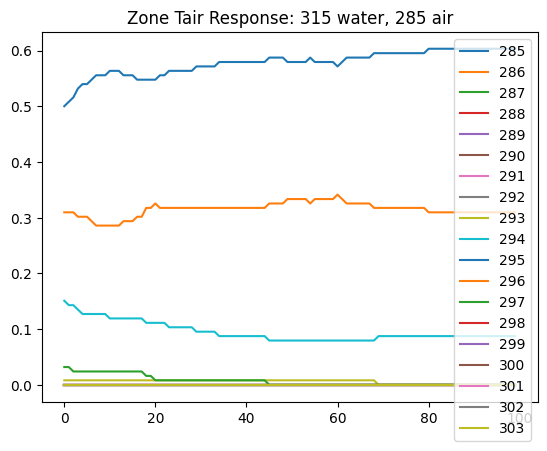

In [183]:
for i in range(285, 304):
    plt.plot(obs_df[f"zone_air_temperature_sensor_h_{i}.00"], label=str(i))
plt.legend()
plt.title("Zone Tair Response: 315 water, 285 air")
plt.show()

In [175]:
list(range(0, 101, 20))

[0, 20, 40, 60, 80, 100]

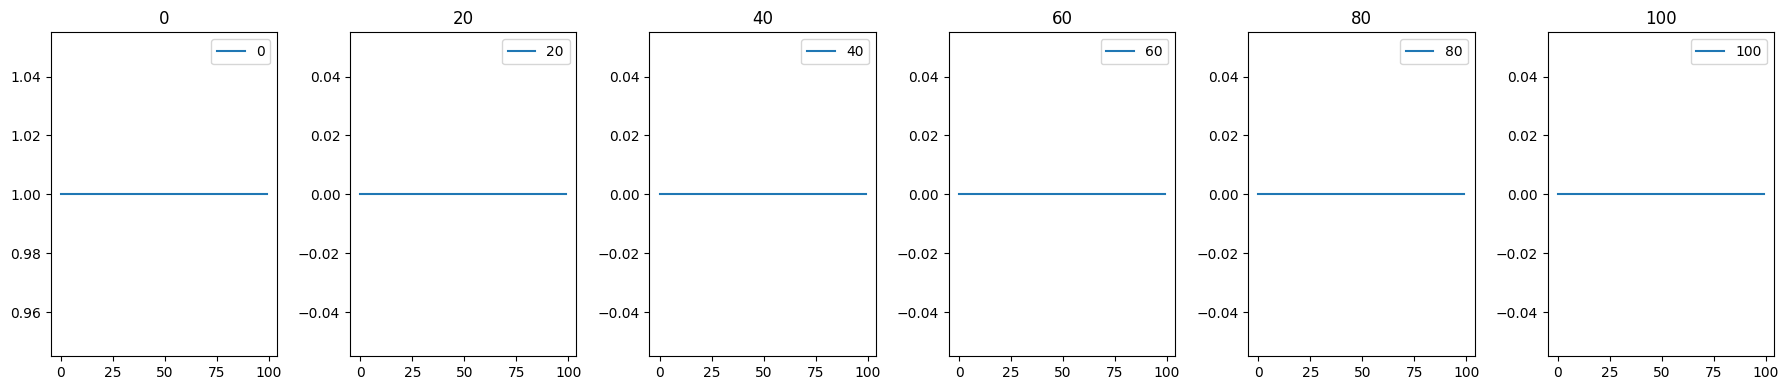

In [178]:
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharex=True)
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate and plot on separate subplots
for idx, i in enumerate(range(0, 101, 20)):  # Iterate over percentages
    formatted_label = f"supply_air_damper_percentage_command_h_{i / 100:.2f}"
    axes[idx].plot(obs_df[formatted_label], label=str(i))
    axes[idx].set_title(str(i))
    axes[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()

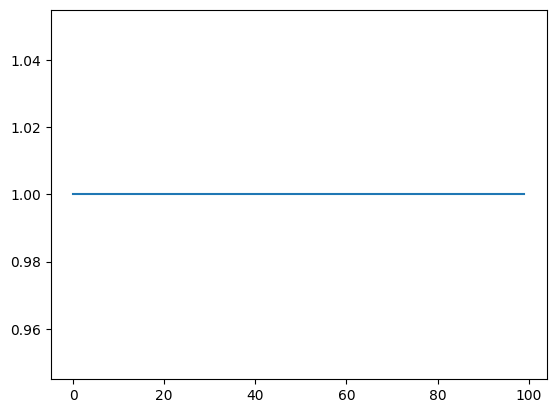

In [151]:
plt.plot(run_info['step_types'])

In [30]:
def compute_avg_return(environment, policy, num_episodes=1, time_zone: str = "US/Pacific", 
                       render_interval_steps: int = 24,trajectory_observers=None,):
    """Computes the average return of the policy on the environment.
    Args:
    environment: environment.Environment
    policy: policy.Policy
    num_episodes: total number of eposides to run.
    time_zone: time zone of the environment
    render_interval_steps: Number of steps to take between rendering.
    trajectory_observers: list of trajectory observers for use in rendering.
    """
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        t0 = time.time()
        epoch = t0
        step_id = 0
        execution_times = []
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)

            if trajectory_observers is not None:
                traj = get_trajectory(time_step, action_step)
                for observer in trajectory_observers:
                    observer(traj)

            episode_return += time_step.reward
            t1 = time.time()
            dt = t1 - t0
            episode_seconds = t1 - epoch
            execution_times.append(dt)
            sim_time = environment.current_simulation_timestamp.tz_convert(time_zone)

            print("Step %5d Sim Time: %s, Reward: %8.2f, Return: %8.2f, Mean Step Time:"
                  " %8.2f s, Episode Time: %8.2f s" % (step_id, sim_time.strftime("%Y-%m-%d %H:%M"),
                                                       time_step.reward, episode_return, 
                                                       np.mean(execution_times), episode_seconds,)
                 )
            if (step_id > 0) and (step_id % render_interval_steps == 0):
                if environment._metrics_path:
                    clear_output(wait=True)
                    reader = get_latest_episode_reader(environment._metrics_path)
                    plot_timeseries_charts(reader, time_zone)
                render_env(environment)

            t0 = t1
            step_id += 1
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return

In [117]:
compute_avg_return(eval_env, schedule_policy, num_episodes=1, render_interval_steps=144, )

Step     0 Sim Time: 2023-07-06 00:05, Reward:    -0.02, Return:    -0.02, Mean Step Time:    30.36 s, Episode Time:    30.36 s
Step     1 Sim Time: 2023-07-06 00:10, Reward:    -0.02, Return:    -0.04, Mean Step Time:    16.41 s, Episode Time:    32.81 s
Step     2 Sim Time: 2023-07-06 00:15, Reward:    -0.02, Return:    -0.06, Mean Step Time:    11.67 s, Episode Time:    35.00 s
Step     3 Sim Time: 2023-07-06 00:20, Reward:    -0.02, Return:    -0.08, Mean Step Time:     9.31 s, Episode Time:    37.23 s
Step     4 Sim Time: 2023-07-06 00:25, Reward:    -0.02, Return:    -0.10, Mean Step Time:     7.91 s, Episode Time:    39.54 s
Step     5 Sim Time: 2023-07-06 00:30, Reward:    -0.02, Return:    -0.12, Mean Step Time:     6.99 s, Episode Time:    41.94 s
Step     6 Sim Time: 2023-07-06 00:35, Reward:    -0.02, Return:    -0.14, Mean Step Time:     6.30 s, Episode Time:    44.13 s
Step     7 Sim Time: 2023-07-06 00:40, Reward:    -0.02, Return:    -0.16, Mean Step Time:     5.80 s, E

KeyboardInterrupt: 

### Necessary Interface: 

Need to pass in policy object such that
- `action_step = policy.action(time_step)` returns an action step item
    - `t_action = tf.convert_to_tensor(action)`
    - `return policy_step.PolicyStep(t_action, (), ())`
- `time_step = environment.step(action_step.action)`
    - action_step.action returns the actual action

In [31]:
policy_step.PolicyStep

tf_agents.trajectories.policy_step.PolicyStep

In [32]:
action_step.action

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.7777778, -1.       ], dtype=float32)>

# SAC and Reward Bufffer

In [33]:
# @title Set the RL Agent's parameters

# Actor network fully connected layers.
actor_fc_layers = (128, 128)
# Critic network observation fully connected layers.
critic_obs_fc_layers = (128, 64)
# Critic network action fully connected layers.
critic_action_fc_layers = (128, 64)
# Critic network joint fully connected layers.
critic_joint_fc_layers = (128, 64)

batch_size = 256
actor_learning_rate = 3e-4
critic_learning_rate = 3e-4
alpha_learning_rate = 3e-4
gamma = 0.99
target_update_tau= 0.005
target_update_period= 1
reward_scale_factor = 1.0

# Replay params
replay_capacity = 1000000
debug_summaries = True
summarize_grads_and_vars = True


In [34]:

# @title Utilities to configure networks for the RL Agent.
dense = functools.partial(
    tf.keras.layers.Dense,
    activation=tf.keras.activations.relu,
    kernel_initializer='glorot_uniform',
)


def logging_info(*args):
    logging.info(*args)
    print(*args)


def create_fc_network(layer_units):
    return sequential.Sequential([dense(num_units) for num_units in layer_units])


def create_identity_layer():
    return tf.keras.layers.Lambda(lambda x: x)


In [35]:
def create_sequential_actor_network(actor_fc_layers, action_tensor_spec):
    """Create a sequential actor network."""

    def tile_as_nest(non_nested_output):
        return tf.nest.map_structure(
                lambda _: non_nested_output, action_tensor_spec
        )

    return sequential.Sequential(
            [dense(num_units) for num_units in actor_fc_layers]
            + [tf.keras.layers.Lambda(tile_as_nest)]
            + [nest_map.NestMap(tf.nest.map_structure(_TanhNormalProjectionNetworkWrapper, 
                                                      action_tensor_spec))])

In [36]:

def create_sequential_critic_network(obs_fc_layer_units, action_fc_layer_units, joint_fc_layer_units):
    """Create a sequential critic network."""
    # Split the inputs into observations and actions.
    def split_inputs(inputs):
        return {'observation': inputs[0], 'action': inputs[1]}

    # Create an observation network.
    obs_network = (
        create_fc_network(obs_fc_layer_units) if obs_fc_layer_units else create_identity_layer()
    )

    # Create an action network.
    action_network = (
        create_fc_network(action_fc_layer_units) if action_fc_layer_units else create_identity_layer()
    )

    # Create a joint network.
    joint_network = (
        create_fc_network(joint_fc_layer_units) if joint_fc_layer_units else create_identity_layer()
    )

    # Final layer.
    value_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform')

    return sequential.Sequential(
        [
            tf.keras.layers.Lambda(split_inputs),
            nest_map.NestMap({'observation': obs_network, 'action': action_network}),
            nest_map.NestFlatten(),
            tf.keras.layers.Concatenate(),
            joint_network,
            value_layer,
            inner_reshape.InnerReshape(current_shape=[1], new_shape=[]),
        ],
        name='sequential_critic',
    )



In [37]:

_, action_tensor_spec, time_step_tensor_spec = spec_utils.get_tensor_specs(
    collect_env
)

In [38]:
class _TanhNormalProjectionNetworkWrapper(
        tanh_normal_projection_network.TanhNormalProjectionNetwork
):
    # rather than producing a value, this makes the output of actor network a DISTRIBUTION over actions
    # sample from [-1,1] via tanh it rather than pick one action. 
    """Wrapper to pass predefined `outer_rank` to underlying projection net."""

    def __init__(self, sample_spec, predefined_outer_rank=1):
        super(_TanhNormalProjectionNetworkWrapper, self).__init__(sample_spec)
        self.predefined_outer_rank = predefined_outer_rank

    def call(self, inputs, network_state=(), **kwargs):
        kwargs['outer_rank'] = self.predefined_outer_rank
        if 'step_type' in kwargs:
            del kwargs['step_type']
        return super(_TanhNormalProjectionNetworkWrapper, self).call(inputs, **kwargs)

In [39]:

actor_net = create_sequential_actor_network(
    actor_fc_layers=actor_fc_layers, action_tensor_spec=action_tensor_spec
)

critic_net = create_sequential_critic_network(
    obs_fc_layer_units=critic_obs_fc_layers,
    action_fc_layer_units=critic_action_fc_layers,
    joint_fc_layer_units=critic_joint_fc_layers,
)


In [40]:
train_step = train_utils.create_train_step()

agent = sac_agent.SacAgent(
    time_step_tensor_spec,
    action_tensor_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate
    ),
    alpha_optimizer=tf.keras.optimizers.Adam(learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=None,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=train_step,
)
agent.initialize()

In [41]:

# @title Access the eval and collect policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

policy_save_interval = 1 # Save the policy after every learning step.
learner_summary_interval = 1 # Produce a summary of the critic, actor, and alpha losses after every gradient update step.


# @title Convert the policies into TF Eager Policies
tf_collect_policy = agent.collect_policy
agent_collect_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_collect_policy, use_tf_function=True)

tf_policy = agent.policy
agent_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_policy, use_tf_function=True)


In [42]:
# Assuming `actor_input_shape` is the shape of the input to the actor network
actor_input_shape = (53,)
actor_net.build(input_shape=(None,) + actor_input_shape)
#actor_net.summary()

In [43]:
obs_shape = (53,)  # Observation shape (replace `obs_dim`)
action_shape = (2,)  # Action shape (replace `action_dim`)

critic_input_shapes = [(None,) + obs_shape, (None,) + action_shape]
critic_net.build(input_shape=critic_input_shapes)
#critic_net.summary()

## Reverb Buffer

In [44]:

# @title Set up the replay buffer
replay_capacity = 50000
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
)

table

Table(sampler=UniformSelector, remover=FifoSelector, max_size=50000, max_times_sampled=0, name=uniform_table, rate_limiter=RateLimiter(samples_per_insert=1, min_diff_=-1.79769e+308, max_diff=1.79769e+308, min_size_to_sample=1), signature=nullptr)

In [50]:
# @title Set up the replay buffer
replay_capacity = 50000
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
)

reverb_checkpoint_dir = output_data_path + "/reverb_checkpoint"
reverb_port = None
print('reverb_checkpoint_dir=%s, port=%s' %(reverb_checkpoint_dir, reverb_port))
reverb_checkpointer = reverb.platform.checkpointers_lib.DefaultCheckpointer(path=reverb_checkpoint_dir)
reverb_server = reverb.Server([table], port=reverb_port, checkpointer=reverb_checkpointer)
logging_info('reverb_server_port=%d' % reverb_server.port)
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server,
)
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    reverb_replay.py_client, table_name, sequence_length=2, stride_length=1
)
print('num_frames in replay buffer=%d' %reverb_replay.num_frames())

reverb_checkpoint_dir=/burg/home/ssa2206/sbsim_dual_contarol/output/reverb_checkpoint, port=None
reverb_server_port=36555
num_frames in replay buffer=0


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /burg/home/ssa2206/sbsim_dual_contarol/output/reverb_checkpoint.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /burg/home/ssa2206/sbsim_dual_contarol/output/reverb_checkpoint
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36555
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [31]:
reverb_replay.num_frames()

0

In [32]:
dataset = reverb_replay.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [33]:
from run_utils import RenderAndPlotObserver, PrintStatusObserver
initial_collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=initial_collect_env
)
initial_collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=initial_collect_env,
    replay_buffer=reverb_replay,
)
collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=collect_env
)
collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=collect_env,
    replay_buffer=reverb_replay,
)
eval_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=eval_env
)
eval_print_status_observer = PrintStatusObserver(
    status_interval_steps=1, environment=eval_env, replay_buffer=reverb_replay
)

In [36]:
reverb_replay.py_client.dataset(table_name)

AttributeError: 'Client' object has no attribute 'dataset'

## World Model

In [1]:
from world_model import LinearWorldModel

2024-12-15 12:49:23.006698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 12:49:23.010753: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 12:49:23.051925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 12:49:23.051963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 12:49:23.053385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
world_model = LinearWorldModel(53, 2, stabilize_dynamics=True)

In [ ]:
all_states = world_model.train(replay_buffer=reverb_replay, batch_size=128, training_steps=256)

In [ ]:
all_states = np.array(all_states).reshape(-1, 53)

plt.plot(all_states_flat[:, 8])

In [ ]:
plt.plot(world_model.state_predictor.prediction_errors, c='red')
plt.title("RLS Online Filtering Algorithm")
plt.xlabel("Batches")
plt.ylabel("Innovation (Error)")
plt.yscale("log")
plt.savefig("/burg/home/ssa2206/sbsim_dual_control/smart_control/notebooks/RLS.png")

In [ ]:
plt.plot(np.array(all_states).mean(axis=0).mean(axis=0), label='actual mean')
plt.plot(world_model.state_predictor.mean, label='stored mean')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(all_states).std(axis=0).std(axis=0), label='actual std')
plt.plot(world_model.state_predictor.std, label='stored std')
plt.legend()
plt.show()

In [ ]:

i = 0
for (experience_batch, sample_info) in dataset:
    print(i)
    states, actions, rewards = experience_batch.observation, experience_batch.action, experience_batch.reward
    at, atp1 = actions[:,0,:], actions[:, 1, :]
    st, stp1 = states[:,0,:], states[:, 1, :]
    RLS.update(st, at, stp1, debug=True)
    i += 1
RLS.prediction_errors

In [ ]:
mag = lambda s : tf.sqrt(tf.reduce_sum(tf.square(s)))

def safe_normalize_state(state, curr_s, curr_a, STATE_BOUND=1000):
    """Normalize state if it exceeds bounds"""
    state_magnitude = mag(state)
    if state_magnitude > STATE_BOUND:
        print(f"State magnitude {state_magnitude} exceeded bound, normalizing...")
        print(mag(curr_s), mag(world_model.state_predictor(curr_s, curr_a)))
        #print(world_model.state_predictor.theta)
        return state * (STATE_BOUND / state_magnitude)
    return state

In [4]:
def generate_rollouts(world_model, initial_state, initial_reward, initial_discount, policy, rollout_length):
    """Generate model-based rollouts with uncertainty estimation."""
    # Convert initial state to tensor and add batch dimension
    current_state = tf.expand_dims(tf.convert_to_tensor(initial_state, dtype=tf.float32), 0)
    current_reward = initial_reward
    current_discount = initial_discount
    generated_experience = []

    time_step = transition(np.array([current_state[0]], dtype=np.float32), reward=current_reward, discount=current_discount)
    action_step = policy.action(time_step)
    current_action = action_step.action

    next_state, reward, (hidden_state, cell_state) = world_model(current_state, current_action)
    state_mag = [mag(next_state)]
    for i in range(rollout_length):
        if(np.isnan(reward).any()):
            break
        else:
            time_step = transition(np.array([next_state[0]], dtype=np.float32), reward=reward, discount=current_discount)
            next_action = policy.action(time_step).action # Get action from policy

            generated_experience.append(
                dict(state=current_state.numpy(), action=current_action, reward=reward,
                next_state= next_state.numpy(), discount=current_discount.reshape(1,1))
            )

            # Update current state
            current_state, current_reward = next_state, reward
            next_state, reward, (hidden_state, cell_state) = world_model(current_state, current_action)
            next_state = safe_normalize_state(next_state, current_state, current_action)
            state_mag.append(mag(next_state))
    return generated_experience, state_mag

In [ ]:
plt.imshow(world_model.state_predictor.theta.numpy())
plt.colorbar()
plt.show()

In [ ]:
singular_values = np.linalg.svd(world_model.state_predictor.theta, compute_uv=False)
singular_values[:5]

In [ ]:
def add_to_replay_buffer(rb_observer, experience_data):
    """
    Adds experience data to the Reverb replay buffer.
    
    Args:
        rb_observer: ReverbAddTrajectoryObserver instance
        experience_data: Dict containing state, action, reward, next_state, discount
    """
    state, action, reward, next_state, discount = experience_data.values()
 
    state = state.reshape(-1) # Remove any extra dimensions
    action = tf.squeeze(action)
    next_state = tf.squeeze(next_state)
    reward = tf.squeeze(reward)
    discount = tf.squeeze(discount)
    # print(f"State shape: {state.shape}")
    # print(f"Action shape: {action.shape}")
    # print(f"Next state shape: {next_state.shape}")
    # print(f"Reward shape: {reward.shape}")
    
    # Create a Trajectory object with the required fields
    traj = trajectory.Trajectory(
        step_type=tf.constant(StepType.MID, dtype=tf.int32),
        observation=tf.constant(state, dtype=tf.float32), # Current observation/state
        action=tf.constant(action, dtype=tf.float32),
        policy_info=(),
        next_step_type=tf.constant(StepType.MID, dtype=tf.int32),
        reward=tf.constant(reward, dtype=tf.float32),
        discount=tf.constant(discount, dtype=tf.float32)
    )
    
    # Add trajectory to replay buffer
    rb_observer(traj)



In [ ]:
exp = generate_rollouts(world_model, initial_state, initial_reward, initial_discount, collect_policy, 100)
f"{type(exp)} of length {len(exp)}; each entry is {type(exp[0])} with keys {exp[0].keys()}"


### Vaibhav OG Code

In [5]:
"""
if run_model_exp:
    # @title Execute the training loop

    num_training_iterations = 10
    num_gradient_updates_per_training_iteration = 100
    

    # Collect the performance results with teh untrained model.
    eval_actor.run_and_log()

    logging_info('Training.')

    world_model = TransformerWorldModel(
        state_dim=collect_env.observation_spec().shape[0],
        action_dim=collect_env.action_spec().shape[0],
        hidden_dim=256,
        num_heads=8,
        num_transformer_blocks=3
    )

    model_buffer = ModelAssistedReplayBuffer(
        real_buffer=reverb_replay,
        world_model=world_model,
        rollout_length=5,
        rollout_ratio=0.5,
        uncertainty_threshold=0.5
    )


    # log_dir = root_dir + '/train'
    # with tf.summary.create_file_writer(log_dir).as_default() as writer:   

    for iter in range(num_training_iterations):
        print('Training iteration: ', iter)

        collect_actor.run()

        world_model_loss = train_world_model(
            world_model=world_model,
            replay_buffer=reverb_replay,
            batch_size=256,
            training_steps=1000
        )
        logging_info(f'World Model Loss: {world_model_loss:.4f}')

        real_batch = next(iter(reverb_replay.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
            num_steps=2
        )))

        initial_states = real_batch.observation[:, 0]
        initial_actions = real_batch.action[:, 0]

        for i in range(len(initial_states)):
            generated_experience = model_buffer.generate_rollouts(
                initial_states[i],
                initial_actions[i],
                agent_collect_policy
            )

            for exp in generated_experience:
                rb_observer(trajectory.from_episode(
                    observation=exp['state'],
                    action=exp['action'],
                    policy_info=(),
                    reward=exp['reward'],
                    discount=1.0
                ))

        loss_info = agent_learner.run(
            iterations=num_gradient_updates_per_training_iteration
        )

        logging_info(
            'Actor Loss: %6.2f, Critic Loss: %6.2f, Alpha Loss: %6.2f'
            % (
                loss_info.extra.actor_loss.numpy(),
                loss_info.extra.critic_loss.numpy(),
                loss_info.extra.alpha_loss.numpy(),
            )
        )

        eval_env.reset()
        eval_actor.run_and_log()

    rb_observer.close()
    reverb_server.stop()
"""

"\nif run_model_exp:\n    # @title Execute the training loop\n\n    num_training_iterations = 10\n    num_gradient_updates_per_training_iteration = 100\n    \n\n    # Collect the performance results with teh untrained model.\n    eval_actor.run_and_log()\n\n    logging_info('Training.')\n\n    world_model = TransformerWorldModel(\n        state_dim=collect_env.observation_spec().shape[0],\n        action_dim=collect_env.action_spec().shape[0],\n        hidden_dim=256,\n        num_heads=8,\n        num_transformer_blocks=3\n    )\n\n    model_buffer = ModelAssistedReplayBuffer(\n        real_buffer=reverb_replay,\n        world_model=world_model,\n        rollout_length=5,\n        rollout_ratio=0.5,\n        uncertainty_threshold=0.5\n    )\n\n\n    # log_dir = root_dir + '/train'\n    # with tf.summary.create_file_writer(log_dir).as_default() as writer:   \n\n    for iter in range(num_training_iterations):\n        print('Training iteration: ', iter)\n\n        collect_actor.run()\n\